In [56]:
"""
Directivity
===========

The directivity module provides tools to work with directivity.

The following conventions are used within this module:

* The inclination angle :math:`\\theta` has a range :math:`[0, \\pi]`.
* The azimuth angle :math:`\\phi` has a range :math:`[0 , 2 \\pi]`.

"""
import abc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp2d as interpolate
from scipy.special import sph_harm  # pylint: disable=no-name-in-module


def cardioid(theta, a=1.0, k=1.0):
    """
    A cardioid pattern.

    :param a: a
    :param k: k
    """
    return np.abs(a + a * np.cos(k * theta))


def figure_eight(theta, phi=0.0):
    """
    A figure-of-eight pattern.

    :param theta: angle :math:`\\theta`
    """
    del phi
    #return spherical_harmonic(theta, phi, m=0, n=1)
    return np.abs(np.cos(theta))


def spherical_harmonic(theta, phi, m=0, n=0):
    """Spherical harmonic of order `m` and degree `n`.

    .. note:: The degree `n` is often denoted `l`.

    .. seealso:: :func:`scipy.special.sph_harm`

    """
    return sph_harm(m, n, phi, theta).real


def spherical_to_cartesian(r, theta, phi):
    """
    Convert spherical coordinates to cartesian coordinates.

    :param r: norm
    :param theta: angle :math:`\\theta`
    :param phi: angle :math:`\\phi`

    .. math:: x = r \\sin{\\theta}\\cos{\\phi}
    .. math:: y = r \\sin{\\theta}\\sin{\\phi}
    .. math:: z = r \\cos{\\theta}
    """
    r = np.asanyarray(r)
    theta = np.asanyarray(theta)
    phi = np.asanyarray(phi)
    return (r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), r * np.cos(theta))


def cartesian_to_spherical(x, y, z):
    """
    Convert cartesian coordinates to spherical coordinates.

    :param x: x
    :param y: y
    :param z: z

    .. math:: r = \\sqrt{\\left( x^2 + y^2 + z^2 \\right)}
    .. math:: \\theta = \\arccos{\\frac{z}{r}}
    .. math:: \\phi = \\arccos{\\frac{y}{x}}
    """
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    z = np.asanyarray(z)
    r = np.linalg.norm(np.vstack((x, y, z)), axis=0)
    return r, np.arccos(z / r), np.arctan(y / x)


class Directivity:
    """
    Abstract directivity class.

    This class defines several methods to be implemented by subclasses.
    """

    def __init__(self, rotation=None):

        self.rotation = rotation if rotation else np.array([1.0, 0.0, 0.0])  # X, Y, Z rotation
        """
        Rotation of the directivity pattern.
        """

    @abc.abstractmethod
    def _directivity(self, theta, phi):
        """
        This function should return the directivity as function of :math:`\\theta` and :math:`\\phi`.
        """

    def _undo_rotation(self, theta, phi):
        """
        Undo rotation.
        """

    def using_spherical(self, r=1, theta, phi, include_rotation=True):
        """
        Return the directivity for given spherical coordinates.

        :param r: norm
        :param theta: angle :math:`\\theta`
        :param phi: angle :math:`\\phi`
        """
        # TODO: Correct for rotation!!!!
        del r, include_rotation
        return self._directivity(theta, phi)

    def using_cartesian(self, x, y, z, include_rotation=True):
        """
        Return the directivity for given cartesian coordinates.

        :param x: x
        :param y: y
        :param z: z
        """
        # TODO: Correct for rotation!!!!
        del include_rotation
        return self.using_spherical(*cartesian_to_spherical(x, y, z))

    def plot(self, filename=None, include_rotation=True):
        """
        Directivity plot. Plot to ``filename`` when given.

        :param filename: Filename
        :param include_rotation: Apply the rotation to the directivity.
            By default the rotation is applied in this figure.
        """
        # TODO: filename
        del filename
        return plot(self, include_rotation)


class Omni(Directivity):
    """
    Class to work with omni-directional directivity.
    """

    def _directivity(self, theta, phi):
        """
        Directivity
        """
        return np.ones_like(theta)


class Cardioid(Directivity):
    """
    Cardioid directivity.
    """

    def _directivity(self, theta, phi):
        """
        Directivity
        """
        return cardioid(theta)


class FigureEight(Directivity):
    """Directivity of a figure of eight.
    """

    def _directivity(self, theta, phi):
        """Directivity
        """
        return figure_eight(theta, phi)


class SphericalHarmonic(Directivity):
    """Directivity of a spherical harmonic of degree `n` and order `m`.
    """

    def __init__(self, rotation=None, m=None, n=None):

        super().__init__(rotation=rotation)
        self.m = m
        """Order `m`.
        """
        self.n = n
        """Degree `n`.
        """

    def _directivity(self, theta, phi):
        """Directivity
        """
        return spherical_harmonic(theta, phi, self.m, self.n)


class Custom(Directivity):
    """
    A class to work with directivity.
    """

    def __init__(self, theta=None, phi=None, r=None):
        """
        Constructor.
        """

        self.theta = theta
        """
        Latitude. 1-D array.
        """
        self.phi = phi
        """
        Longitude. 1-D array.
        """
        self.r = r
        """
        Magnitude or radius. 2-D array.
        """

    def _directivity(self, theta, phi):
        """
        Custom directivity.

        Interpolate the directivity given longitude and latitude vectors.
        """
        f = interpolate(self.theta, self.phi, self.r)

        return f(theta, phi)


def plot(d, sphere=False):
    """
    Plot directivity `d`.

    :param d: Directivity
    :type d: :class:`Directivity`

    :returns: Figure
    """
    theta, phi = np.meshgrid(np.linspace(0.0, np.pi, 50), np.linspace(0.0, +2.0 * np.pi, 50))

    # Directivity strength. Real-valued. Can be positive and negative.
    dr = d.using_spherical(100,theta, phi)

    if sphere:
        x, y, z = spherical_to_cartesian(1.0, theta, phi)

    else:
        x, y, z = spherical_to_cartesian(np.abs(dr), theta, phi)
    #R, theta, phi = cartesian_to_spherical(x, y, z)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #p = ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)

    norm = Normalize()
    norm.autoscale(dr)
    colors = cm.jet(norm(dr))
    m = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    m.set_array(dr)
    ax.plot_surface(x, y, z, facecolors=colors, rstride=1, cstride=1, linewidth=0)
    plt.colorbar(m, ax=ax)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    return fig


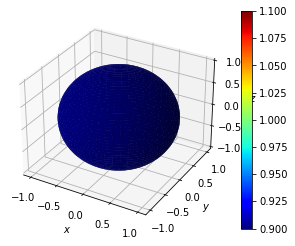

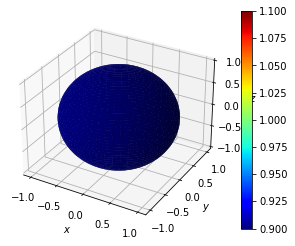

In [57]:
a = Omni()
a.plot()

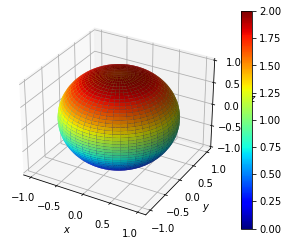

In [59]:
d = Cardioid()
fig = d.plot(include_rotation=True)

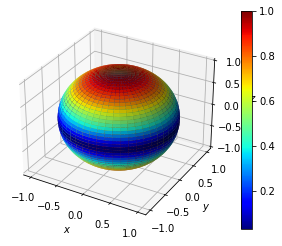

In [60]:
d = FigureEight()
fig = d.plot()


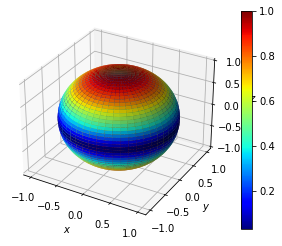

In [62]:
fig = d.plot(include_rotation=True)

In [63]:
d.using_spherical(np.pi/4.0, np.pi/4.0)

TypeError: using_spherical() missing 1 required positional argument: 'phi'

In [64]:
d.using_cartesian(0.5, 0.5, 0.5)

array([0.57735027])

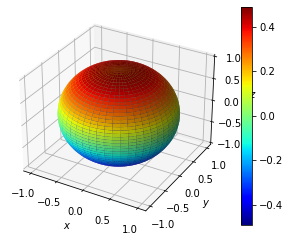

In [65]:
d = SphericalHarmonic(m=0, n=1)
fig = d.plot()

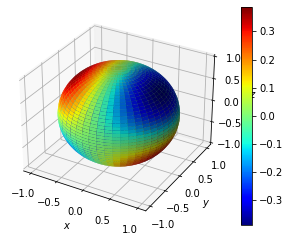

In [66]:
d = SphericalHarmonic(m=1, n=2)
fig = d.plot()

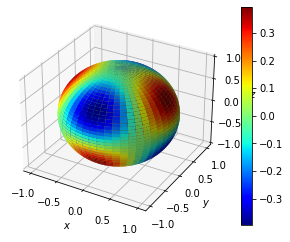

In [67]:
d = SphericalHarmonic(m=-2, n=3)
fig = d.plot()